In [2]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Define paths
dataset_path = "D:\\CBIR\\dataset"
feature_save_path = "features.npy"
paths_save_path = "image_paths.npy"

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()
model = model.cuda() if torch.cuda.is_available() else model

# Transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features
def extract_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.cuda() if torch.cuda.is_available() else image
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()

# Collect features and paths
features = []
image_paths = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            image_paths.append(img_path)
            feature = extract_features(img_path, model, transform)
            features.append(feature)

features = np.array(features)
np.save(feature_save_path, features)
np.save(paths_save_path, image_paths)


In [1]:
import numpy as np

# Load features and image paths
features = np.load("features.npy")
image_paths = np.load("image_paths.npy", allow_pickle=True)


In [ ]:
#Image Retrieval Using FAISS

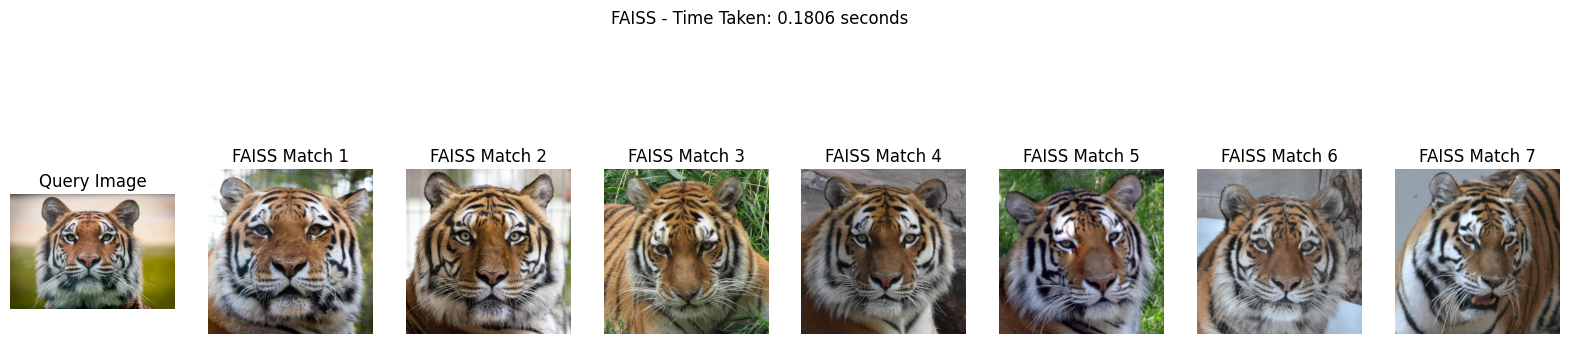

In [5]:
import faiss
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

# Function to create FAISS index
def create_faiss_index(features):
    dim = features.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(features)
    return index

# Function to query FAISS
def query_faiss(query_image_path, index, model, transform, k=7):
    query_feature = extract_features(query_image_path, model, transform).reshape(1, -1)
    distances, indices = index.search(query_feature, k)
    return [image_paths[i] for i in indices[0]]

# Function to display images
def display_images(query_image_path, similar_images, method_name, time_taken):
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(20, 5))
    query_image = Image.open(query_image_path).convert('RGB')
    axes[0].imshow(query_image)
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    for i, img_path in enumerate(similar_images):
        image = Image.open(img_path).convert('RGB')
        axes[i + 1].imshow(image)
        axes[i + 1].set_title(f'{method_name} Match {i+1}')
        axes[i + 1].axis('off')
    plt.suptitle(f'{method_name} - Time Taken: {time_taken:.4f} seconds')
    plt.show()

# Example query
query_image_path = r"D:\tiger.jpg"

# FAISS
try:
    index = create_faiss_index(features)
    start_time = time.time()
    faiss_results = query_faiss(query_image_path, index, model, transform)
    faiss_time = time.time() - start_time
    display_images(query_image_path, faiss_results, 'FAISS', faiss_time)
except Exception as e:
    print(f"An error occurred with FAISS: {e}")
